# Evaluate Outputs

This notebook evaluates outputs of the recommendation model(s).

## Setup

What data set?

In [1]:
data = 'ml-latest-small'

Let's import some things:

In [2]:
from pathlib import Path
import re
import logging

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import ttest_rel
import statsmodels.api as sm

In [5]:
from lenskit import topn
from lenskit.datasets import MovieLens
from lenskit.util.log import log_to_notebook

In [6]:
_log = logging.getLogger('eval-notebook')
log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


In [7]:
from tqdm.notebook import tqdm
tqdm.pandas()

## Load Data

### Test Data

We're going to start by loading the test data:

In [8]:
ml = MovieLens(f'data/{data}')
split_dir = Path(f'data/{data}-split')

In [9]:
movies = ml.movies
movies.head()

,title,genres
item,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Scan for and load test data:

In [10]:
test_re = re.compile(r'^part(?P<part>\d+)-test')
test_frames = {}
for file in split_dir.glob('*-test.parquet'):
    match = test_re.match(file.name)
    part = int(match.group('part'))
    test_frames[part] = pd.read_parquet(file)

In [11]:
test_ratings = pd.concat(test_frames, names=['part'])
test_ratings = test_ratings.reset_index('part').reset_index(drop=True)
test_ratings.head()

,part,user,item,rating,timestamp
0,1,3,849,5.0,1306463611
1,1,3,3024,4.5,1306464054
2,1,3,6238,0.5,1306464204
3,1,3,1371,3.0,1306463561
4,1,3,26409,4.5,1306463993


### Outputs

Now let's load prediction & recommendation data.

A regular expression will parse file names:

In [12]:
adn_re = re.compile(r'^(?P<data>.*?)-(?P<algo>[A-Z].*)')
fn_re = re.compile(r'part(?P<part>\d+)-(?:recs|preds)')

Load predictions:

In [13]:
pred_frames = {}
for file in Path('preds').glob(f'{data}-*/*-preds.parquet'):
    _log.info('loading %s', file)
    dmatch = adn_re.match(file.parent.name)
    algo = dmatch.group('algo')
    fmatch = fn_re.match(file.name)
    part = int(fmatch.group('part'))
    df = pd.read_parquet(file)
    pred_frames[(algo, part)] = df

[   INFO] eval-notebook loading preds/ml-latest-small-BIAS/part3-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-BIAS/part2-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-BIAS/part5-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-BIAS/part1-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-BIAS/part4-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-E-MF/part1-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-E-MF/part4-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-E-MF/part2-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-E-MF/part3-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-E-MF/part5-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-TorchMF/part1-preds.parquet
[   INFO] eval-notebook loading preds/ml-latest-small-TorchMF/part4-preds.parquet
[   INFO] eval-notebook loading preds/ml-lates

In [14]:
preds = pd.concat(pred_frames, names=['algo', 'part'])
preds = preds.reset_index(['algo', 'part']).reset_index(drop=True)
preds.head()

,algo,part,user,item,rating,timestamp,prediction
0,BIAS,3,6,145,4.0,845553966,3.525638
1,BIAS,3,6,267,3.0,845554376,3.233138
2,BIAS,3,6,207,4.0,845554024,3.695638
3,BIAS,3,6,370,4.0,845553794,3.339497
4,BIAS,3,6,440,4.0,845553457,3.835638


And now the recommendations:

In [15]:
rec_frames = {}
for file in Path('recs').glob(f'{data}-*/*-recs.parquet'):
    _log.info('loading %s', file)
    dmatch = adn_re.match(file.parent.name)
    algo = dmatch.group('algo')
    fmatch = fn_re.match(file.name)
    part = int(fmatch.group('part'))
    df = pd.read_parquet(file)
    rec_frames[(algo, part)] = df

[   INFO] eval-notebook loading recs/ml-latest-small-POP/part1-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-POP/part3-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-POP/part2-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-POP/part5-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-POP/part4-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-BIAS/part4-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-BIAS/part1-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-BIAS/part2-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-BIAS/part5-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-BIAS/part3-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-E-MF/part1-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-E-MF/part4-recs.parquet
[   INFO] eval-notebook loading recs/ml-latest-small-E-MF/part3-recs.parquet
[   

In [16]:
recs = pd.concat(rec_frames, names=['algo', 'part'])
recs = recs.reset_index(['algo', 'part']).reset_index(drop=True)
recs.head()

,algo,part,item,score,user,rank
0,POP,1,356,326.0,3,1
1,POP,1,318,315.0,3,2
2,POP,1,296,303.0,3,3
3,POP,1,593,275.0,3,4
4,POP,1,2571,274.0,3,5


## Prediction Accuracy

Now, let's compute the per-user RMSE of each algorithm.

In [17]:
preds['sqerr'] = np.square(preds['rating'] - preds['prediction'])
user_rmse = preds.groupby(['algo', 'user'])['sqerr'].mean()
user_rmse = user_rmse.to_frame('RMSE').reset_index()
user_rmse.head()

,algo,user,RMSE
0,BIAS,1,0.562860
1,BIAS,2,0.533294
2,BIAS,3,10.611165
3,BIAS,4,0.974652
4,BIAS,5,0.407355


Numeric summaries of RMSE:

In [18]:
user_rmse.groupby('algo')['RMSE'].describe()

,count,mean,std,min,25%,50%,75%,max
algo,,,,,,,,
BIAS,610.0,0.863622,0.868381,0.019067,0.298599,0.621093,1.134121,10.611165
E-MF,610.0,0.798236,0.744504,0.008215,0.298879,0.599034,1.015741,5.249447
TorchMF,610.0,1.100733,0.839359,0.027152,0.518580,0.936055,1.462143,5.191026


Plot it:

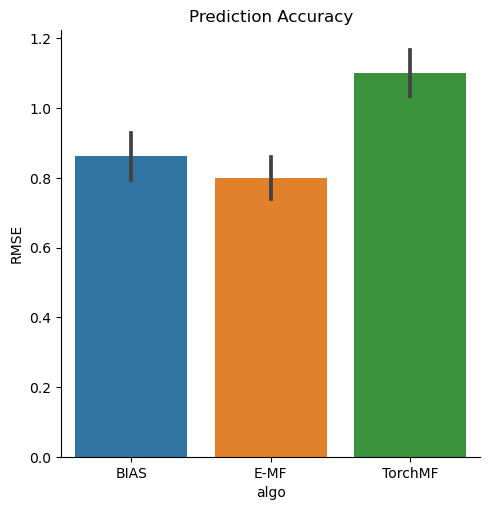

In [19]:
sns.catplot(user_rmse, x='algo', y='RMSE', kind='bar')
plt.title('Prediction Accuracy')
plt.show()

### Statistical Inference

We have these metrics, how do we do inference on them?  The confidence intervals indicate some significance, but we haven't taken into account the **non-independence** of measurements: each RMSE depends on the user across different algorithms!

For testing *two* algorithms, we can use a paired t-test:

In [20]:
rmse_wide = user_rmse.pivot(index='user', columns='algo', values='RMSE')
rmse_wide.head()

algo,BIAS,E-MF,TorchMF
user,,,
1,0.562860,0.510012,0.176816
2,0.533294,0.636404,0.966291
3,10.611165,4.860860,2.802737
4,0.974652,0.567745,0.724872
5,0.407355,0.836590,0.558571


ttest_rel(rmse_wide['BIAS'], rmse_wide['TorchMF'])

Now, we have a very large sample size. We are always very likely to find significance!

For testing multiple ones at the same time, we effectively have a **repeated-measures** problem: each algorithm is measured multiple times, once for each algorithm.  We could use repeated-measures ANOVA, but this doesn't work if measures are missing for any elements, which is the case if we don't get recommendations or predictions for a user.

The geneal solution is a **mixed-effects model**.

- With 2 levels of our experiment variable, it is equivalent to a paired T-test
- With complete data (every user-algo pair is observed), it is equivalent to a repeated-measures ANOVA

Statsmodels provides this.

We need our **exogenous** variables (in statsmodels terms), which are:

- all but 1 algorithm (we will use `Bias` as our baseline)

We aren't going to bother with a global intercept - we will let the per-user intercept take care of that.

In [21]:
rmse_algos = pd.get_dummies(user_rmse['algo']).drop(columns=['BIAS'])
rmse_algos

,E-MF,TorchMF
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1825,0,1
1826,0,1
1827,0,1
1828,0,1


rmse_lm = sm.MixedLM(np.log(user_rmse['RMSE']), rmse_algos, user_rmse['user'])
rmse_fit = rmse_lm.fit()
rmse_fit.summary()

rmse_resid = rmse_fit.resid

sm.qqplot(rmse_resid, line='45', scale=True)

## Recommendation Utility

Now let's evaluate the top-*N* recommendations.

In [22]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.hit, k=20)
rla.add_metric(topn.recip_rank, k=20)
rla.add_metric(topn.ndcg, k=20)
user_scores = rla.compute(recs, test_ratings)
user_scores.reset_index(inplace=True)
user_scores

[   INFO] lenskit.topn analyzing 97600 recommendations (3050 truth rows)
[   INFO] lenskit.topn using rec key columns ['algo', 'part', 'user']
[   INFO] lenskit.topn using truth key columns ['part', 'user']
[   INFO] lenskit.topn numbering truth lists
[   INFO] lenskit.topn numbering rec lists
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.topn measured 4880 lists in  40ms


,algo,part,user,nrecs,hit,recip_rank,ndcg
0,POP,1,3,20,0.0,0.000000,0.000000
1,POP,1,5,20,1.0,0.166667,0.224513
2,POP,1,14,20,1.0,0.058824,0.052481
3,POP,1,17,20,1.0,1.000000,0.541232
4,POP,1,20,20,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...
4875,TorchLMF,5,598,20,0.0,0.000000,0.000000
4876,TorchLMF,5,599,20,1.0,1.000000,0.342212
4877,TorchLMF,5,602,20,0.0,0.000000,0.000000
4878,TorchLMF,5,605,20,1.0,0.050000,0.091203


In [23]:
us_tall = user_scores.melt(id_vars=['algo', 'user'], value_vars=['recip_rank', 'hit', 'ndcg'], var_name='Metric')
us_tall

,algo,user,Metric,value
0,POP,3,recip_rank,0.000000
1,POP,5,recip_rank,0.166667
2,POP,14,recip_rank,0.058824
3,POP,17,recip_rank,1.000000
4,POP,20,recip_rank,0.000000
...,...,...,...,...
14635,TorchLMF,598,ndcg,0.000000
14636,TorchLMF,599,ndcg,0.342212
14637,TorchLMF,602,ndcg,0.000000
14638,TorchLMF,605,ndcg,0.091203


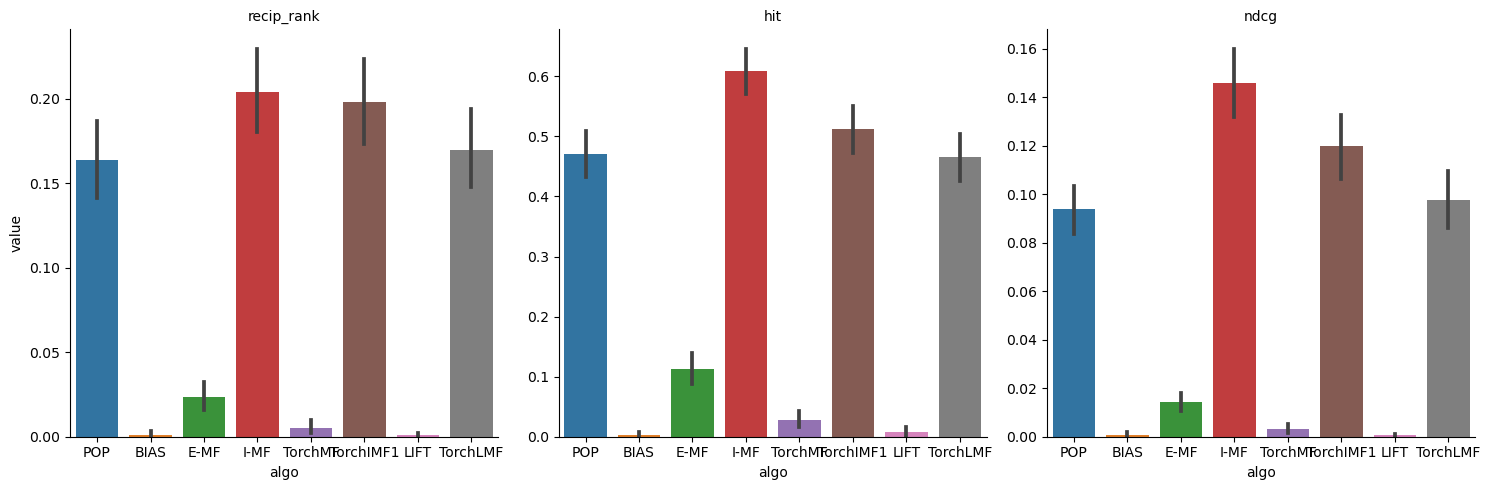

In [24]:
g = sns.catplot(us_tall, x='algo', y='value', col='Metric', kind='bar', sharey=False)
g.set_titles('{col_name}')
g.set_xlabels(None)
plt.show()